In [1]:
import os
import platform
import sys

if platform.system() == 'Windows':
    midi_ddsp_module_path = os.path.abspath(os.path.join('../../'))
    ddsp_module_path = os.path.abspath(os.path.join('../../../ddsp-playground-2/'))
else:
    midi_ddsp_module_path = os.path.abspath(os.path.join('../../'))
    ddsp_module_path = os.path.abspath(os.path.join('../../../ddsp/ddsp-playground-2/'))

def apply_module_path(module_path):
    print(f"module_path={module_path}")
    if module_path not in sys.path:
      sys.path.append(module_path)
      print(f"appending {module_path} to sys.path")
    else:
      print(f"do not appending {module_path} to sys.path")

apply_module_path(midi_ddsp_module_path)
apply_module_path(ddsp_module_path)

import sys
if platform.system() != 'Windows':
    sparsenet_module_path_abs = '/ssd003/home/burakovr/projects/vova/envs/main/lib/python3.8/site-packages/'
    apply_module_path(sparsenet_module_path_abs)

import midi_ddsp

module_path=E:\Code\Projects\TimbreTransfer\midi-ddsp-main
do not appending E:\Code\Projects\TimbreTransfer\midi-ddsp-main to sys.path
module_path=E:\Code\Projects\TimbreTransfer\ddsp-playground-2
appending E:\Code\Projects\TimbreTransfer\ddsp-playground-2 to sys.path


E:\Code\Projects\TimbreTransfer\midi-ddsp-main\midi_ddsp\midi_ddsp_synthesize.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


nn.py sys.path=['E:\\Code\\Projects\\TimbreTransfer\\midi-ddsp-main\\midi_ddsp\\colab', 'E:\\Code\\Projects\\TimbreTransfer\\midi-ddsp-main', 'E:\\Code\\Software\\Python38\\python38.zip', 'E:\\Code\\Software\\Python38\\DLLs', 'E:\\Code\\Software\\Python38\\lib', 'E:\\Code\\Software\\Python38', 'e:\\code\\projects\\coursework\\ddsp-playground\\ddsp-playground-2', '', 'e:\\code\\projects\\coursework\\ddsp-playground\\ddsp-playground-2\\lib\\site-packages', 'e:\\code\\projects\\coursework\\ddsp-playground\\ddsp-playground-2\\lib\\site-packages\\win32', 'e:\\code\\projects\\coursework\\ddsp-playground\\ddsp-playground-2\\lib\\site-packages\\win32\\lib', 'e:\\code\\projects\\coursework\\ddsp-playground\\ddsp-playground-2\\lib\\site-packages\\Pythonwin', 'E:\\Code\\Projects\\TimbreTransfer\\ddsp-playground-2', 'E:/Code/Projects/Coursework/ddsp-playground/ddsp-playground-2/Lib/site-packages']
0


In [2]:
#  Copyright 2022 The MIDI-DDSP Authors.
#  #
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#  #
#      http://www.apache.org/licenses/LICENSE-2.0
#  #
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.

"""Training code for Synthesis Generator."""

import tensorflow as tf
import time
import os
import sys
import logging
import argparse
import IPython

from keras.utils.layer_utils import print_summary
from livelossplot import PlotLosses

from midi_ddsp.data_handling.get_dataset import get_dataset
from midi_ddsp.utils.training_utils import print_hparams, set_seed, \
    save_results, str2bool
from midi_ddsp.utils.summary_utils import write_tensorboard_audio
#                          from midi_ddsp.hparams_synthesis_generator import hparams as hp
from midi_ddsp.hparams_synthesis_generator import hparams_debug as hp
from midi_ddsp.modules.recon_loss import ReconLossHelper
from midi_ddsp.modules.gan_loss import GANLossHelper
from midi_ddsp.modules.get_synthesis_generator import get_synthesis_generator, \
    get_fake_data_synthesis_generator
from midi_ddsp.modules.discriminator import Discriminator

from ddsp.colab.notebook_utils import play, specplot

In [28]:
hp.data_dir = '../../data/'
hp.batch_size = 1 # for saving to TFRecord purposes

In [29]:
# Load dataset.
training_data, length_training_data, evaluation_data, length_evaluation_data = get_dataset(hp, training_data_repeats=1)

In [30]:
eval_sample_batch = next(iter(evaluation_data))
train_sample_batch = next(iter(training_data))
logging.info('Data loaded! Data size: %s', str(length_training_data))

In [44]:
training_example = next(iter(training_data))
play(training_example['audio'])

In [32]:
print(training_data)

<PrefetchDataset element_spec={'audio': TensorSpec(shape=(1, 64000), dtype=tf.float32, name=None), 'f0_confidence': TensorSpec(shape=(1, 1000), dtype=tf.float32, name=None), 'f0_hz': TensorSpec(shape=(1, 1000, 1), dtype=tf.float32, name=None), 'instrument_id': TensorSpec(shape=(1,), dtype=tf.int32, name=None), 'loudness_db': TensorSpec(shape=(1, 1000, 1), dtype=tf.float32, name=None), 'note_active_frame_indices': TensorSpec(shape=(1, 1000, 128), dtype=tf.float32, name=None), 'note_active_velocities': TensorSpec(shape=(1, 1000, 128), dtype=tf.float32, name=None), 'note_offsets': TensorSpec(shape=(1, 128000), dtype=tf.float32, name=None), 'note_onsets': TensorSpec(shape=(1, 128000), dtype=tf.float32, name=None), 'power_db': TensorSpec(shape=(1, 1000), dtype=tf.float32, name=None), 'recording_id': TensorSpec(shape=(1,), dtype=tf.string, name=None), 'midi': TensorSpec(shape=(1, 1000), dtype=tf.int64, name=None), 'onsets': TensorSpec(shape=(1, 1000), dtype=tf.int64, name=None), 'offsets': T

In [33]:
#hp.data_dir = '../data/'

hp.training_epochs = 32 # 5k steps
hp.log_interval = 1
hp.checkpoint_save_interval = 1
hp.eval_interval = 1
hp.synth_coder_training_epochs = 24
hp.batch_size=10
#hp.batch_size=1
hp.reverb_length = 16000
experiment_name = "experiment_tflite_and_debug"

In [34]:
midi_ddsp_model = get_synthesis_generator(hp)
midi_ddsp_model(eval_sample_batch)
midi_ddsp_model.summary()

MIDIExpressionAE.__call__()
SynthCoder.__call__()
MelF0LDEncoder.__call__()
FCHarmonicDecoder.__call__()
debug: DAGLayer(<class 'ddsp.processors.ProcessorGroup'>) received input={'f0_hz': <tf.Tensor: shape=(3, 1000, 1), dtype=float32, numpy=
array([[[329.9369 ],
        [329.86127],
        [329.78568],
        ...,
        [330.56146],
        [330.91586],
        [331.3262 ]],

       [[367.1112 ],
        [367.04114],
        [366.97314],
        ...,
        [589.61584],
        [588.9996 ],
        [588.36633]],

       [[316.42538],
        [316.4605 ],
        [316.4141 ],
        ...,
        [373.20862],
        [373.60303],
        [373.6359 ]]], dtype=float32)>, 'amplitudes': <tf.Tensor: shape=(3, 1000, 1), dtype=float32, numpy=
array([[[0.98729706],
        [1.0046334 ],
        [1.0190636 ],
        ...,
        [1.0974278 ],
        [1.1056077 ],
        [1.1167573 ]],

       [[0.9876436 ],
        [1.0046654 ],
        [1.018826  ],
        ...,
        [1.0926232 ],
  

In [35]:
midi_ddsp_model.load_weights('logs/logs_synthesis_generator/experiment_5/e24_s4655')

In [39]:
synthcoder = midi_ddsp_model.synth_coder
tf.keras.Model.summary(synthcoder, expand_nested=True)

Model: "synth_coder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mel_f0ld_encoder (MelF0LDEn  multiple                 7054912   
 coder)                                                          
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| cnn8 (Cnn8)               multiple                  4689984   |
||¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯||
|| conv_block (ConvBlock)  multiple                  37952     ||
|||¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|||
||| conv2d (Conv2D)       multiple                  576       |||
|||                                                           |||
||| conv2d_1 (Conv2D)     multiple                  36864     |||
|||                                                           |||
||| batch_normalization (BatchN  multiple           256       |||
||| ormalization)                                      

In [40]:
play(midi_ddsp_model(training_example)['synth_audio'])

MIDIExpressionAE.__call__()
SynthCoder.__call__()
MelF0LDEncoder.__call__()


KeyboardInterrupt: 

In [202]:
def add_feature_synth_harmonic_amplitudes(sample):

    keys_to_keep = [
                'f0_hz',
                'loudness_db',
                'synth_amplitudes',
                'onsets',
                'offsets']

    synthcoder_features = synthcoder(sample)
    sample['synth_amplitudes'] = synthcoder_features['amplitudes']

    # Remove from the sample features that are not necessary for training an Onsets/Offsets extractor

    # remove batch dim
    return {key: sample[key][0] for key in keys_to_keep}

training_data_for_extractor = training_data.map(add_feature_synth_harmonic_amplitudes)

SynthCoder.__call__()
MelF0LDEncoder.__call__()
FCHarmonicDecoder.__call__()


In [185]:
evaluation_data_for_extractor = evaluation_data.map(add_feature_synth_harmonic_amplitudes)

SynthCoder.__call__()
MelF0LDEncoder.__call__()
FCHarmonicDecoder.__call__()


In [203]:
print({k: v.shape for k, v in (next(iter(training_data_for_extractor))).items()})

{'f0_hz': TensorShape([1000, 1]), 'loudness_db': TensorShape([1000, 1]), 'synth_amplitudes': TensorShape([1000, 1]), 'onsets': TensorShape([1000]), 'offsets': TensorShape([1000])}


In [204]:
q = 0
for sample in training_data_for_extractor:
    print(sample.keys())
    q = q + 1
    print(q)

print(f"total: {q}")

dict_keys(['f0_hz', 'loudness_db', 'synth_amplitudes', 'onsets', 'offsets'])
1
dict_keys(['f0_hz', 'loudness_db', 'synth_amplitudes', 'onsets', 'offsets'])
2
dict_keys(['f0_hz', 'loudness_db', 'synth_amplitudes', 'onsets', 'offsets'])
3
dict_keys(['f0_hz', 'loudness_db', 'synth_amplitudes', 'onsets', 'offsets'])
4
dict_keys(['f0_hz', 'loudness_db', 'synth_amplitudes', 'onsets', 'offsets'])
5
dict_keys(['f0_hz', 'loudness_db', 'synth_amplitudes', 'onsets', 'offsets'])
6
dict_keys(['f0_hz', 'loudness_db', 'synth_amplitudes', 'onsets', 'offsets'])
7
dict_keys(['f0_hz', 'loudness_db', 'synth_amplitudes', 'onsets', 'offsets'])
8
dict_keys(['f0_hz', 'loudness_db', 'synth_amplitudes', 'onsets', 'offsets'])
9
dict_keys(['f0_hz', 'loudness_db', 'synth_amplitudes', 'onsets', 'offsets'])
10
dict_keys(['f0_hz', 'loudness_db', 'synth_amplitudes', 'onsets', 'offsets'])
11
dict_keys(['f0_hz', 'loudness_db', 'synth_amplitudes', 'onsets', 'offsets'])
12
dict_keys(['f0_hz', 'loudness_db', 'synth_amplitu

In [205]:
smpl = next(iter(training_data_for_extractor))
print({k : v.dtype for k, v in smpl.items()})

{'f0_hz': tf.float32, 'loudness_db': tf.float32, 'synth_amplitudes': tf.float32, 'onsets': tf.int64, 'offsets': tf.int64}


In [206]:
def serialize_example(f0_hz, loudness_db, onsets, offsets, synth_amplitudes):
    features = {
        'f0_hz':            tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.serialize_tensor(f0_hz).numpy()])),
        'loudness_db':      tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.serialize_tensor(loudness_db).numpy()])),
        'synth_amplitudes': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.serialize_tensor(synth_amplitudes).numpy()])),
        'onsets':           tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.serialize_tensor(onsets).numpy()])),
        'offsets':          tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.serialize_tensor(offsets).numpy()])),
    }

    example_proto = tf.train.Example(features=tf.train.Features(feature=features))
    return example_proto.SerializeToString()

In [207]:
def tf_serialize_example(sample):
    f0_hz = sample["f0_hz"]
    loudness_db = sample["loudness_db"]
    onsets = sample["onsets"]
    offsets = sample["offsets"]
    synth_amplitudes = sample["synth_amplitudes"]

    tf_string = tf.py_function(
        serialize_example,
        inp=[f0_hz, loudness_db, onsets, offsets, synth_amplitudes],
        Tout=tf.string,
    )
    return tf.reshape(tf_string, ())

In [209]:
serialized_dataset = training_data_for_extractor.map(tf_serialize_example)

In [208]:
filename = "onsets_offsets_extractor_training_binary.tfrecord"

In [210]:
with tf.io.TFRecordWriter(filename) as writer:
    for serialized_example in serialized_dataset:
        writer.write(serialized_example.numpy())

In [3]:
def parse_example(example_proto):
    feature_description = {
        "f0_hz":            tf.io.FixedLenFeature([], dtype=tf.string),
        "loudness_db":      tf.io.FixedLenFeature([], dtype=tf.string),
        "synth_amplitudes": tf.io.FixedLenFeature([], dtype=tf.string),
        "onsets":           tf.io.FixedLenFeature([], dtype=tf.string),
        "offsets":          tf.io.FixedLenFeature([], dtype=tf.string),
    }
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)

    for key in parsed_example:
        parsed_example[key] = tf.io.parse_tensor(parsed_example[key], out_type=tf.float32 if key not in ["onsets", "offsets"] else tf.int64)

    # parsed_example["f0_hz"] =            tf.reshape(parsed_example["f0_hz"], ),
    # parsed_example["loudness_db"] =      parsed_example["loudness_db"],
    # parsed_example["synth_amplitudes"] = parsed_example["synth_amplitudes"],
    # parsed_example["onsets"] =           parsed_example["onsets"],
    # parsed_example["offsets"] =          parsed_example["offsets"],

    return parsed_example

In [12]:
training_data_for_extractor = tf.data.TFRecordDataset(filenames=['onsets_offsets_extractor_training_binary.tfrecord']).map(parse_example)

evaluation_data_for_extractor = tf.data.TFRecordDataset(filenames=['onsets_offsets_extractor_eval_binary.tfrecord']).map(parse_example)

In [13]:
print(training_data_for_extractor)
print(evaluation_data_for_extractor)

<MapDataset element_spec={'f0_hz': TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), 'loudness_db': TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), 'offsets': TensorSpec(shape=<unknown>, dtype=tf.int64, name=None), 'onsets': TensorSpec(shape=<unknown>, dtype=tf.int64, name=None), 'synth_amplitudes': TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)}>
<MapDataset element_spec={'f0_hz': TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), 'loudness_db': TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), 'offsets': TensorSpec(shape=<unknown>, dtype=tf.int64, name=None), 'onsets': TensorSpec(shape=<unknown>, dtype=tf.int64, name=None), 'synth_amplitudes': TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)}>


In [14]:
batch_size = 16
BUF_SIZE = 100

b_training_data_for_extractor = training_data_for_extractor.batch(batch_size=batch_size, drop_remainder=True).repeat(count=1).shuffle(BUF_SIZE)
b_evaluation_data_for_extractor = evaluation_data_for_extractor.batch(batch_size=batch_size, drop_remainder=True).repeat(count=1).shuffle(BUF_SIZE)

In [15]:
print(b_training_data_for_extractor)
print(b_evaluation_data_for_extractor)

<ShuffleDataset element_spec={'f0_hz': TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), 'loudness_db': TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), 'offsets': TensorSpec(shape=<unknown>, dtype=tf.int64, name=None), 'onsets': TensorSpec(shape=<unknown>, dtype=tf.int64, name=None), 'synth_amplitudes': TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)}>
<ShuffleDataset element_spec={'f0_hz': TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), 'loudness_db': TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), 'offsets': TensorSpec(shape=<unknown>, dtype=tf.int64, name=None), 'onsets': TensorSpec(shape=<unknown>, dtype=tf.int64, name=None), 'synth_amplitudes': TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)}>


In [18]:
print(next(iter(b_training_data_for_extractor)))

AttributeError: 'dict' object has no attribute 'shape'

In [19]:
def numeric_derivative_1d(tensor):
    forward_difference = tf.subtract(tensor[1:], tensor[:-1])
    backward_difference = tf.subtract(tensor[-1], tensor[-2])
    central_difference = tf.divide(tf.subtract(tensor[2:], tensor[:-2]), tf.constant(2.0))

    return tf.concat([forward_difference[:1], central_difference, backward_difference[None]], axis=0)


def numeric_derivative_3d(tensor):
    return tf.map_fn(numeric_derivative_1d, tensor)

In [20]:
kModelFrameSize = 1024

@tf.custom_gradient
def round_with_gradients(x):
    def grad(dy):
        return dy
    return tf.round(x), grad

@tf.custom_gradient
def cast_with_gradients(x):
    def grad(dy):
        return dy
    return tf.cast(x, tf.float32), grad

class RoundFloat32Layer(tf.keras.layers.Layer):
    def call(self, x):
        # return a float32 rounded value from x
        rounded = round_with_gradients(x)
        return cast_with_gradients(rounded)



amplitudes = tf.keras.layers.Input(shape=(1000, 1), name='amplitudes')
f0_hz = tf.keras.layers.Input(shape=(1000, 1), name='f0_hz')

amps_derivative = amplitudes
f0_hz_derivative = f0_hz
amps_derivative = numeric_derivative_1d(amplitudes)
f0_hz_derivative = numeric_derivative_1d(f0_hz)

print(amps_derivative.shape)
print(f0_hz_derivative.shape)

#amps_derivative = tf.squeeze(amps_derivative, axis=-1)
#f0_hz_derivative = tf.squeeze(f0_hz_derivative, axis=-1)

#x = tf.matmul(tf.transpose(amplitudes), f0_hz)
#x = tf.matmul(tf.transpose(amplitudes), f0_hz)
#x = amps_derivative * f0_hz_derivative
x = tf.keras.layers.Conv1D(1,  3, activation='relu', padding='same', input_shape=(None, 1000, 1))(amps_derivative)
x = tf.keras.layers.Conv1D(4,  3, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv1D(4,  3, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv1D(1,  3, activation='relu', padding='same')(x)

y = tf.keras.layers.Conv1D(1,  3, activation='relu', padding='same', input_shape=(None, 1000, 1))(f0_hz_derivative)
y = tf.keras.layers.Conv1D(4,  3, activation='relu', padding='same')(y)
y = tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same')(y)
y = tf.keras.layers.Conv1D(4,  3, activation='relu', padding='same')(y)
y = tf.keras.layers.Conv1D(1,  3, activation='relu', padding='same')(y)

z = tf.add(x, y)

z = tf.keras.layers.Flatten()(z)
z = tf.expand_dims(z, axis=-1)

z = tf.keras.layers.GlobalMaxPooling1D()(z)

onsets = tf.keras.layers.Dense(1000, activation='sigmoid')(z)
offsets = tf.keras.layers.Dense(1000, activation='sigmoid')(z)

onsets = RoundFloat32Layer()(onsets)
offsets = RoundFloat32Layer()(offsets)

#model = tf.keras.Model(inputs=inputs, outputs={'onsets': onsets, 'offsets': offsets})
model = tf.keras.Model(inputs=[amplitudes, f0_hz], outputs=onsets)

(None, 1000, 1)
(None, 1000, 1)


In [21]:
print(b_training_data_for_extractor)

<ShuffleDataset element_spec={'f0_hz': TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), 'loudness_db': TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), 'offsets': TensorSpec(shape=<unknown>, dtype=tf.int64, name=None), 'onsets': TensorSpec(shape=<unknown>, dtype=tf.int64, name=None), 'synth_amplitudes': TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)}>


In [22]:
sample_data = next(iter(b_training_data_for_extractor))

In [23]:
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
outs = model({'amplitudes': sample_data['synth_amplitudes'], 'f0_hz': sample_data['f0_hz']})
model.summary()

print(outs)
#print(outs['onsets'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 amplitudes (InputLayer)        [(None, 1000, 1)]    0           []                               
                                                                                                  
 f0_hz (InputLayer)             [(None, 1000, 1)]    0           []                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 1000, 1)     0           ['amplitudes[0][0]']             
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 1000, 1)     0           ['amplitudes[0][0]']         

In [24]:
# Define the loss function
loss_fn = tf.keras.losses.MeanSquaredError()
#loss_fn = tf.nn.ctc_loss()

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [25]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5390327096309507743
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2915486926
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14560718769947924746
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
 xla_global_id: 416903419]

In [26]:
epochs = 100

for epoch in range(epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_loss_eval_avg = tf.keras.metrics.Mean()

    for step_idx, training_input_item in enumerate(training_data_for_extractor):
        with tf.GradientTape() as tape:
            predictions = model({'f0_hz': training_input_item['f0_hz'],
                                'amplitudes': training_input_item['synth_amplitudes']},
                                training=True)
            #print(type(predictions))
            #print(predictions)
            #print(f"gt.shape={tf.cast(training_input_item['onsets'], tf.float32).shape}")
            #print(f"predictions.shape={predictions.shape}")
            loss = loss_fn(tf.cast(training_input_item['onsets'], tf.float32), predictions)
            print(f"Step #{step_idx}: loss = {loss}")
            #loss = loss_fn(predictions['onsets'], tf.cast(training_input_item['onsets'], tf.float32))
        gradients = tape.gradient(loss, model.trainable_variables)
        #print(f"gradients={gradients}")
        #print(f"trainable_variables={len(model.trainable_variables)}")
        #print(f"tape={tape}")
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        epoch_loss_avg.update_state(loss)

    for eval_item in evaluation_data_for_extractor:
        predictions = model({'f0_hz': eval_item['f0_hz'],
                             'amplitudes': eval_item['synth_amplitudes']},
                            training=False)
        loss = loss_fn(tf.cast(eval_item['onsets'], tf.float32), predictions)
        epoch_loss_eval_avg.update_state(loss)

    print(f'Epoch {epoch+1}: loss={epoch_loss_avg.result().numpy():.5f}, val_los={epoch_loss_eval_avg.result().numpy():.5f}')

Step #0: loss = 0.2168079912662506
Step #1: loss = 0.023000000044703484
Step #2: loss = 0.01899999938905239
Step #3: loss = 0.02800000086426735
Step #4: loss = 0.019999997690320015
Step #5: loss = 0.03599999472498894
Step #6: loss = 0.019999997690320015
Step #7: loss = 0.01600000262260437
Step #8: loss = 0.012999999336898327
Step #9: loss = 0.020999999716877937
Step #10: loss = 0.017000002786517143
Step #11: loss = 0.01799999736249447
Step #12: loss = 0.025002000853419304
Step #13: loss = 0.020999999716877937
Step #14: loss = 0.023000000044703484
Step #15: loss = 0.02199999988079071
Step #16: loss = 0.020999999716877937
Step #17: loss = 0.020999999716877937
Step #18: loss = 0.01799999736249447
Step #19: loss = 0.02300400100648403
Step #20: loss = 0.017000002786517143
Step #21: loss = 0.014000000432133675
Step #22: loss = 0.025999998673796654
Step #23: loss = 0.012000001035630703
Step #24: loss = 0.014000000432133675
Step #25: loss = 0.014999999664723873
Step #26: loss = 0.0149999996647


KeyboardInterrupt



In [19]:
!pip uninstall -y matplotlib
!pip install matplotlib

ERROR: Exception:
Traceback (most recent call last):
  File "E:\Code\Projects\Coursework\ddsp-playground\ddsp-playground-2\lib\site-packages\pip\_internal\cli\base_command.py", line 180, in _main
    status = self.run(options, args)
  File "E:\Code\Projects\Coursework\ddsp-playground\ddsp-playground-2\lib\site-packages\pip\_internal\commands\uninstall.py", line 89, in run
    uninstall_pathset.commit()
  File "E:\Code\Projects\Coursework\ddsp-playground\ddsp-playground-2\lib\site-packages\pip\_internal\req\req_uninstall.py", line 442, in commit
    self._moved_paths.commit()
  File "E:\Code\Projects\Coursework\ddsp-playground\ddsp-playground-2\lib\site-packages\pip\_internal\req\req_uninstall.py", line 282, in commit
    save_dir.cleanup()
  File "E:\Code\Projects\Coursework\ddsp-playground\ddsp-playground-2\lib\site-packages\pip\_internal\utils\temp_dir.py", line 184, in cleanup
    rmtree(self._path)
  File "E:\Code\Projects\Coursework\ddsp-playground\ddsp-playground-2\lib\site-packa

Found existing installation: matplotlib 3.7.1
Uninstalling matplotlib-3.7.1:
  Successfully uninstalled matplotlib-3.7.1


You should consider upgrading via the 'E:\Code\Projects\Coursework\ddsp-playground\ddsp-playground-2\Scripts\python.exe -m pip install --upgrade pip' command.


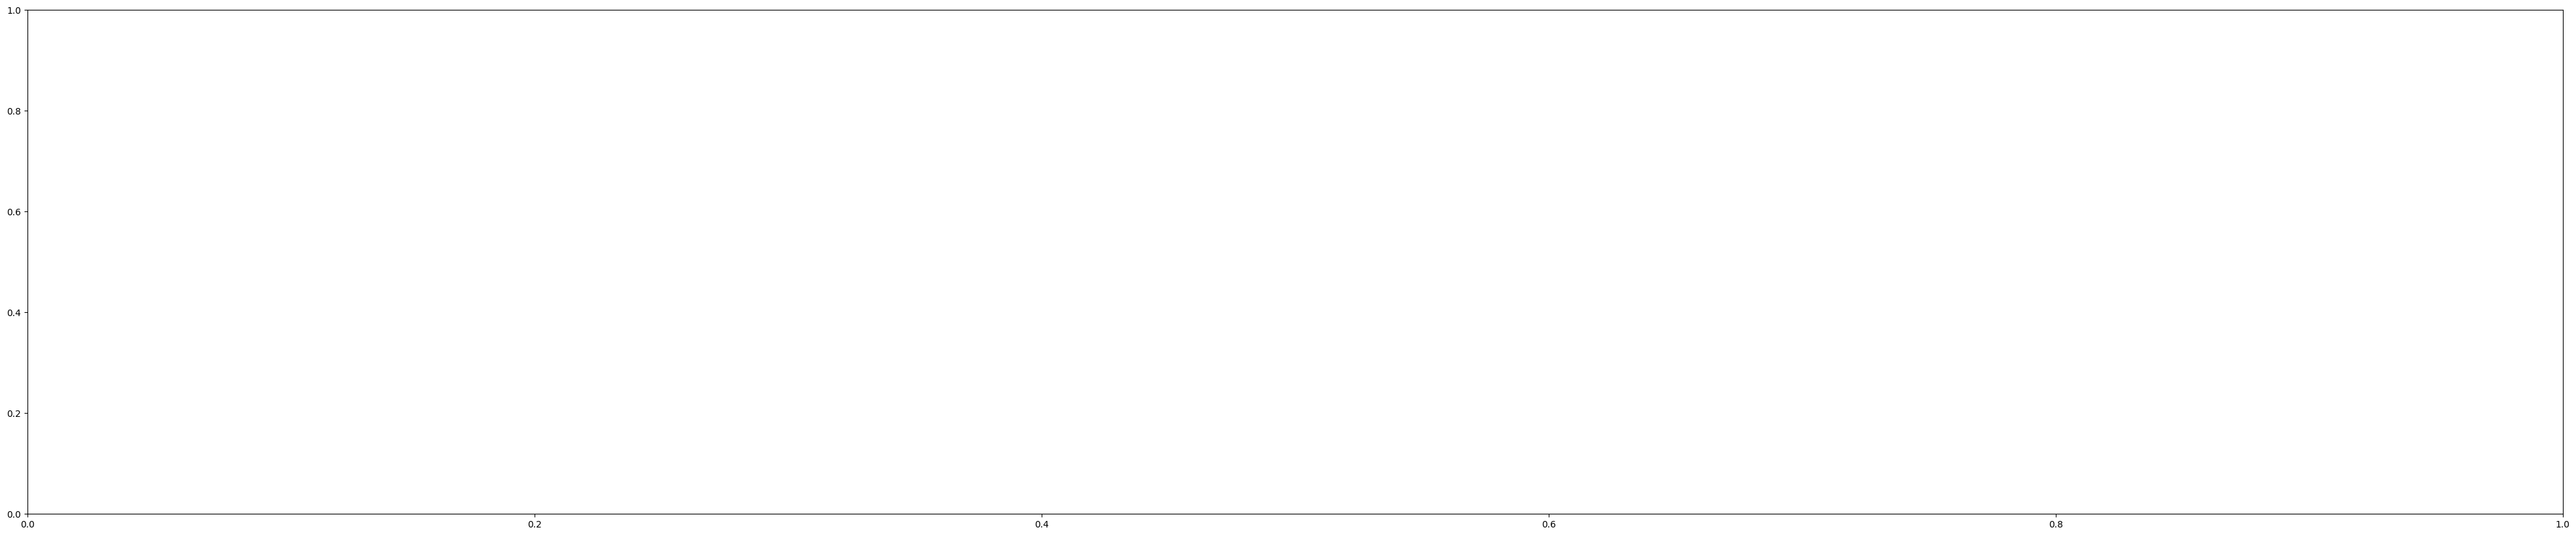

In [16]:
import matplotlib.pyplot as plt
from ddsp.colab.notebook_utils import play, specplot

fig, ax = plt.subplots(figsize=(50,10))

In [19]:

for ii, ex in enumerate(iter(training_data)):
    data_item = ex

    if ii == 15:
        break

data_item = training_example
play(data_item['audio'][0])

In [18]:
synthcoder_features = synthcoder(data_item)

amps = synthcoder_features['amplitudes']
dv = numeric_derivative_1d(amps[0])
print(tf.shape(dv))

SynthCoder.__call__()
MelF0LDEncoder.__call__()
FCHarmonicDecoder.__call__()
tf.Tensor([1000    1], shape=(2,), dtype=int32)


SynthCoder.__call__()
MelF0LDEncoder.__call__()
FCHarmonicDecoder.__call__()
onsets shape = [1000]
f0_hz shape = [1000    1]


min_db.shape=()
loudness_db.shape=(1000,)
mean_db.shape=()
smoothened_f0_confidence.shape=(1000,)
ld_diff.shape=(1000,)
db.shape=(1000,)
db_threshold.shape=()
note_on_ratio.shape=(1000,)
mask_on.shape=(1000,)
generated_note_on_ratio.shape=(1000,)
generated_mask_on.shape=(1000,)
pitch.shape=(1000, 1)
masked_pitch.shape=(892, 1)
int_mask.shape=(1000,)
synthcoder_features['harmonic_distribution'].shape=(2, 1000, 60)
synthcoder_features['amplitudes'].shape=(2, 1000, 1)


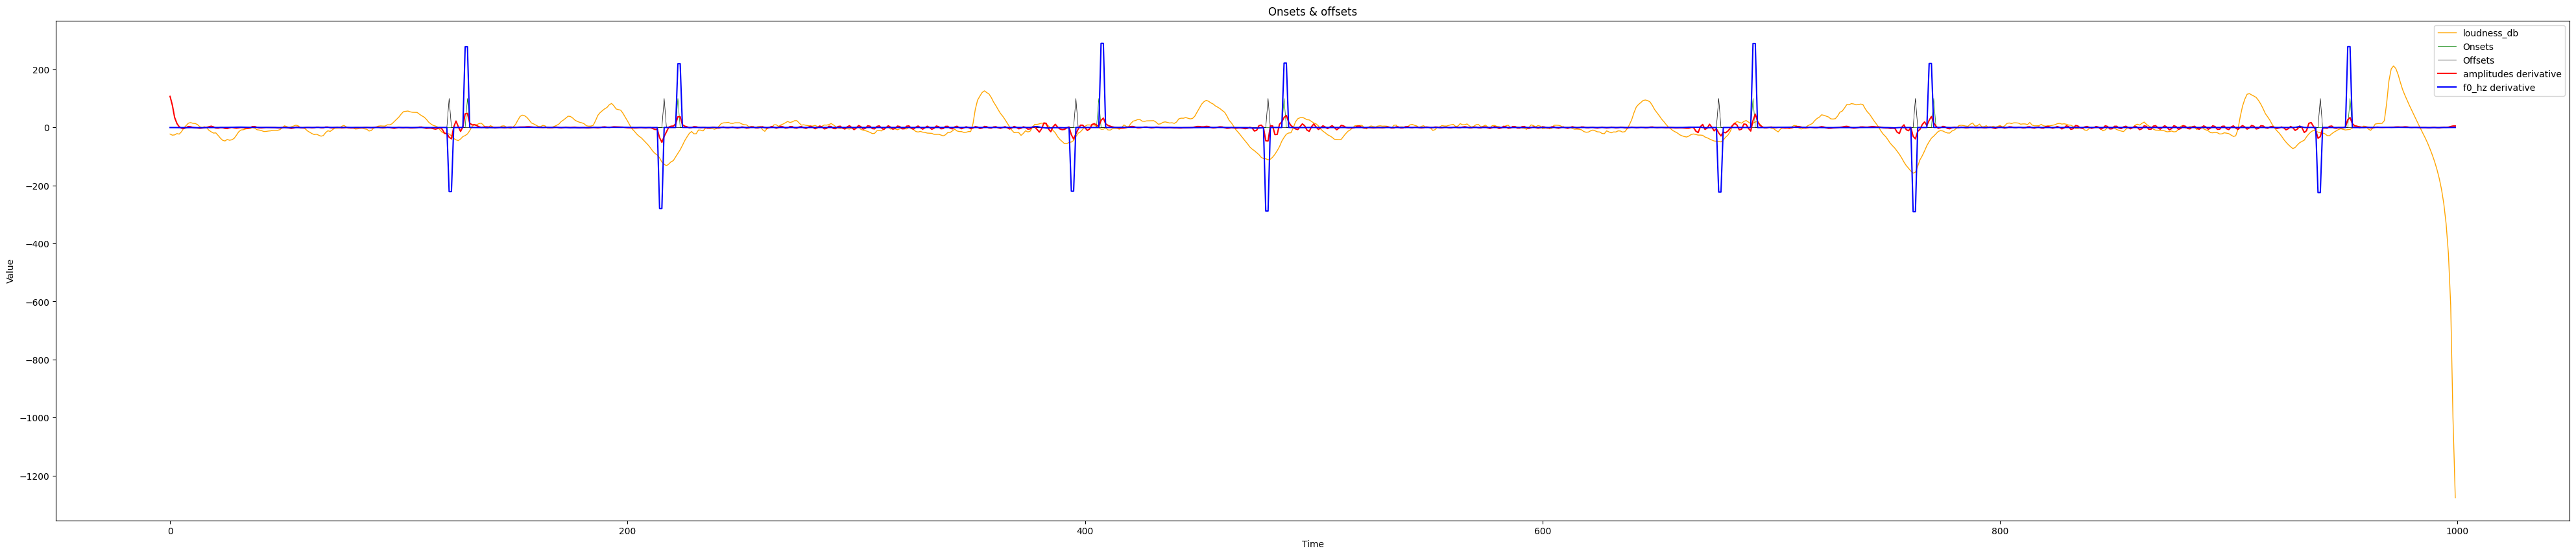

In [22]:
from ddsp import spectral_ops
import ddsp
from ddsp.training.postprocessing import (detect_notes, smooth)
import numpy as np

def detect_notes_v2(loudness_db,
                 f0_confidence,
                 note_threshold=1.0,
                 exponent=2.0,
                 smoothing=40,
                 f0_confidence_threshold=0.7,
                 min_db=-spectral_ops.DB_RANGE):
  """Detect note on-off using loudness and smoothed f0_confidence."""

  # loudness_db should have 1 dim
  loudness_db = tf.squeeze(loudness_db, axis=-1)

  assert(len(loudness_db.shape) == 1)

  min_db = tf.constant(min_db, dtype=tf.float32)
  print(f"min_db.shape={min_db.shape}")
  print(f"loudness_db.shape={loudness_db.shape}")

  mean_db = tf.math.reduce_mean(loudness_db)
  print(f"mean_db.shape={mean_db.shape}")

  smoothened_f0_confidence = smooth(f0_confidence**exponent, smoothing)
  print(f"smoothened_f0_confidence.shape={smoothened_f0_confidence.shape}")

  ld_diff = (loudness_db - min_db)
  print(f"ld_diff.shape={ld_diff.shape}")

  db = smoothened_f0_confidence * ld_diff
  print(f"db.shape={db.shape}")

  db_threshold = (mean_db - min_db) * f0_confidence_threshold**exponent
  print(f"db_threshold.shape={db_threshold.shape}")

  note_on_ratio = db / db_threshold
  print(f"note_on_ratio.shape={note_on_ratio.shape}")

  mask_on = note_on_ratio >= note_threshold
  print(f"mask_on.shape={mask_on.shape}")

  return mask_on, note_on_ratio

synthcoder_features = synthcoder(data_item)

ii = 0
onsets = data_item['onsets'][ii]
print(f"onsets shape = {tf.shape(onsets)}")
offsets = data_item['offsets'][ii]
f0_hz = data_item['f0_hz'][ii]
print(f"f0_hz shape = {tf.shape(f0_hz)}")
f0_confidence = data_item['f0_confidence'][ii]
loudness_db = data_item['loudness_db'][ii]
midis = data_item['midi'][ii]
play(data_item['audio'][ii])

generated_mask_on, generated_note_on_ratio = detect_notes_v2(loudness_db=data_item['loudness_db'][ii], f0_confidence=data_item['f0_confidence'][ii])

pitch = ddsp.core.hz_to_midi(data_item['f0_hz'][ii])
masked_pitch = pitch[generated_mask_on]
int_mask = tf.where(generated_mask_on, 100, 0)

print(f"generated_note_on_ratio.shape={generated_note_on_ratio.shape}")
print(f"generated_mask_on.shape={generated_mask_on.shape}")
print(f"pitch.shape={pitch.shape}")
print(f"masked_pitch.shape={masked_pitch.shape}")
print(f"int_mask.shape={int_mask.shape}")
#im = ax.imshow(generated_mask_on)
#plt.show()
#print(f"pitch={pitch}")
#print(f"pitch={masked_pitch}")
print(f"synthcoder_features['harmonic_distribution'].shape={synthcoder_features['harmonic_distribution'].shape}")
print(f"synthcoder_features['amplitudes'].shape={synthcoder_features['amplitudes'].shape}")
#plt.locator_params(nbins=30)

#ax = plt.gca()
ax.clear()
#ax.set_ylim([0, 20])

#ax.set_ylim([0, 125])
#ax.plot(loudness_db, 'orange', label='loudness_db', linewidth=1)
#ax.plot(numeric_derivative_1d(loudness_db) * 100, 'orange', label='loudness_db', linewidth=1)
#ax.plot(f0_hz, 'cyan', label='f0_hz', linewidth=2)

#ax.matshow(np.log10(tf.transpose(synthcoder_features['harmonic_distribution'][0], perm=[1, 0]) + 1e-6), cmap=plt.cm.magma, origin='lower')
ax.plot(onsets * 100, 'g', label='Onsets', linewidth=0.5)
ax.plot(offsets * 100, '#000000', label='Offsets', linewidth=0.5)
#ax.plot(synthcoder_features['amplitudes'][0] * 100, '#995995', label='amplitudes')


ax.plot(numeric_derivative_1d(synthcoder_features['amplitudes'][0]) * 100, 'red', label='amplitudes derivative')
#ax.plot(numeric_derivative_1d(synthcoder_features['amplitudes'][0]) * numeric_derivative_1d(f0_hz), 'red', label='amplitudes derivative')
#ax.plot(generated_mask_on * 100, 'red', label='generated_mask_on')
ax.plot(numeric_derivative_1d(f0_hz), 'blue', label='f0_hz derivative')

#ax.plot(synthcoder_features['amplitudes'][0] * f0_hz, '#4DACCA', label='amplitudes * f0_hz')
#ax.plot(synthcoder_features['amplitudes'][0] * f0_hz, '#995995', label='amplitudes')
ax.set_title('Onsets & offsets')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend()
fig
#fig.show()

#plt.close('all')
#plt.clf()
#plt.cla()
#plt.close('all')

In [ ]:
generated_mask_on